In [1]:
suppressPackageStartupMessages({
    library(monocle)
    
    library(RColorBrewer)
    library(dplyr)
    library(ggplot2)
    library(pheatmap)
    library(reshape2)
    library(scales)
})

Warning message:
“replacing previous import by ‘splines::splineDesign’ when loading ‘VGAM’”Warning message:
“replacing previous import by ‘grid::arrow’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘grid::unit’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::clusters’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘ggplot2::Position’ when loading ‘monocle’”

This analysis was made using Monocle version 2.3.5. The source code for Monocle 2.3.5 is available as a supplementary file to Cao et al. 2017 on the Science website. We are working on updating the analysis to the latest version of Monocle.

In [3]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.8 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] scales_0.4.1        reshape2_1.4.2      pheatmap_1.0.8     
 [4] dplyr_0.7.1         RColorBrewer_1.1-2  monocle_2.3.5      
 [7] DDRTree_0.1.5       irlba_2.2.1         VGAM_1.0-3         
[10] ggplot2_2.2.1       Biobase_2.30.0      BiocGenerics_0.16.1
[13] Matrix_1.2-7.1     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11           bind

In [ ]:
# at certain "checkpoints" in this notebook, we save our progress to this RData file
# run this cell to load your progress if you have already reached through one or more checkpoints in the notebook

# IF YOU RUN THIS CELL DO NOT RUN THE CELL BELOW

load("RData/L2.anterior.posterior.stuff.RData")

In [68]:
load("RData/L2.data.summaries.RData")

In [3]:
cds.bwm = cds.experiment.1[, with(pData(cds.experiment.1), !is.na(cell.type) & cell.type == "Body wall muscle")]

In [4]:
pData(cds.bwm)$tni.3 = expresses.gene(cds.bwm, "tni-3")
pData(cds.bwm)$cwn.1 = expresses.gene(cds.bwm, "cwn-1")
pData(cds.bwm)$egl.20 = expresses.gene(cds.bwm, "egl-20")

pData(cds.bwm)$marker.gene = with(pData(cds.bwm), ifelse(
    tni.3 + cwn.1 + egl.20 > 1, "Multiple", ifelse(
    tni.3, "tni-3", ifelse(
    cwn.1, "cwn-1", ifelse(
    egl.20, "egl-20", "None")))))

pData(cds.bwm)$marker.gene = factor(pData(cds.bwm)$marker.gene, levels = c(
    "tni-3", "cwn-1", "egl-20", "Multiple", "None"))

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

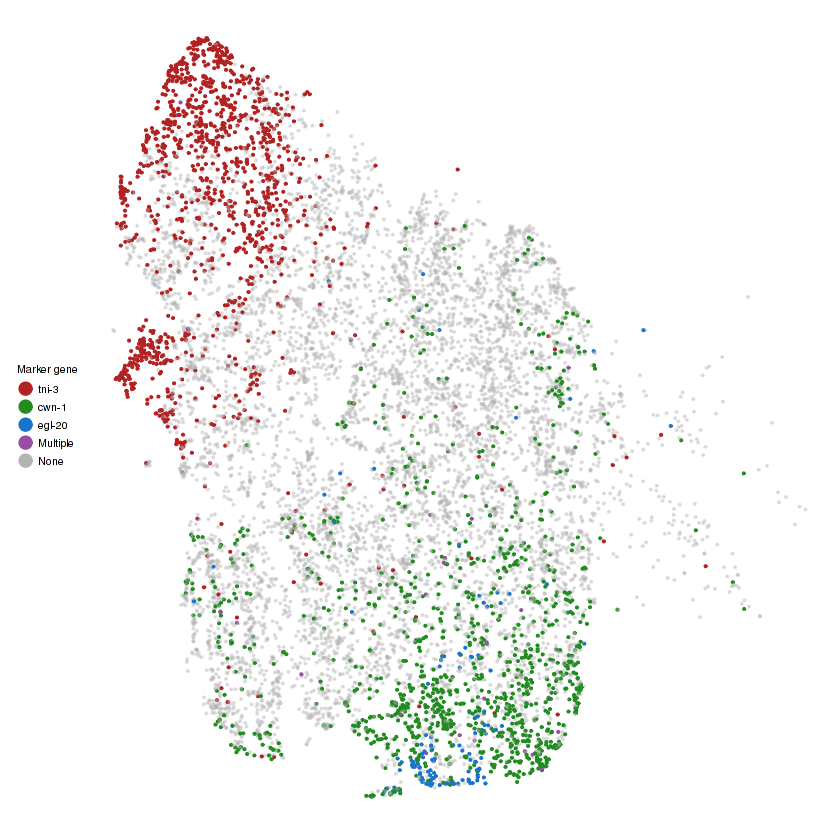

In [5]:
plot = ggplot(pData(cds.bwm), aes(x = tsne_1, y = tsne_2, color = marker.gene, alpha = marker.gene)) +
    geom_point(size = 0.1) +
    scale_color_manual(values = c("firebrick", "forestgreen", "dodgerblue3", "#984EA3", "grey70")) +
    scale_alpha_manual(values = c(1, 1, 1, 1, 1.0/3.0)) +
    guides(
        color = guide_legend(title = "Marker gene", override.aes = list(size = 3)),
        alpha = F) +
    theme_void() +
    monocle:::monocle_theme_opts() +
    theme(
        axis.line = element_blank(),
        legend.position = "left",
        legend.title = element_text(size=6),
        legend.text = element_text(size=6),
        legend.margin = margin(0, -10, 0, 10),
        legend.key.width = unit(0.15, "in"),
        legend.key.height = unit(0.15, "in"))

show(plot)

ggsave("plots/Fig_S8a.pdf", plot = plot,
    device = cairo_pdf, units = "in", width = 3, height = 2.5)

In [64]:
pData(cds.bwm)$ap = with(pData(cds.bwm), ifelse(
    tni.3 & !(cwn.1 | egl.20), "Anterior", ifelse(
    !tni.3 & (cwn.1 | egl.20), "Posterior", NA)))

pData(cds.bwm)$ap = factor(pData(cds.bwm)$ap, levels = c("Anterior", "Posterior"))

cds.bwm.ap = cds.bwm[, !is.na(pData(cds.bwm)$ap)]
cds.bwm.ap = detectGenes(cds.bwm.ap, 0.1)
summary(cds.bwm.ap$ap)

expressed.genes = subset(fData(cds.bwm.ap), num_cells_expressed >= 10)$gene_id
length(expressed.genes)

Anterior Posterior 
     1231      1267

[1] 7071

In [65]:
BWM.AP.DE.genes = differentialGeneTest(cds.bwm.ap[expressed.genes,],
    fullModelFormulaStr = "~ ap")

In [71]:
BWM.AP.norm.means = sapply(c("Anterior", "Posterior"), function(x) {
    rowMeans(norm.expr[, pData(cds)$cell %in% subset(pData(cds.bwm.ap), ap == x)$cell])
})

rownames(BWM.AP.norm.means) = fData(cds)$symbol

In [73]:
BWM.AP.DE.genes = inner_join(BWM.AP.DE.genes, data.frame(
    symbol = row.names(BWM.AP.norm.means), 
    anterior.tpm = (BWM.AP.norm.means[, "Anterior"] / sum(BWM.AP.norm.means[, "Anterior"])) * 1000000,
    posterior.tpm = (BWM.AP.norm.means[, "Posterior"] / sum(BWM.AP.norm.means[, "Posterior"])) * 1000000
), by = "symbol") %>% mutate(
    A.P.ratio = anterior.tpm / (posterior.tpm + 1),
    P.A.ratio = posterior.tpm / (anterior.tpm + 1),
    log2.fc = ifelse(A.P.ratio > 1, log2(A.P.ratio), -log2(P.A.ratio))) %>% select(
    gene_id, symbol, qval, anterior.tpm, posterior.tpm, log2.fc)

In [92]:
sum(BWM.AP.DE.genes$qval < 0.05 & abs(BWM.AP.DE.genes$log2.fc) >= log2(3))
BWM.AP.DE.genes %>% arrange(qval) %>% head(10)

[1] 372

gene_id,symbol,qval,anterior.tpm,posterior.tpm,log2.fc,sig.group
WBGene00006585,tni-3,0.000000e+00,3690.25012,0.00000,11.849503,"Significant, FC >= 3"
WBGene00011880,T21B6.3,0.000000e+00,6105.79011,47.40676,6.978826,"Significant, FC >= 3"
WBGene00018271,F41C3.5,4.015542e-189,516.73435,5664.76731,-3.451733,"Significant, FC >= 3"
WBGene00002268,lec-5,7.953391e-161,198.12769,2712.67643,-3.767951,"Significant, FC >= 3"
WBGene00000857,cwn-1,3.173923e-158,0.00000,1254.76107,-10.293197,"Significant, FC >= 3"
WBGene00001386,far-2,7.313183e-142,763.48546,5336.08465,-2.803221,"Significant, FC >= 3"
WBGene00001863,him-4,1.362482e-111,512.57157,3555.50747,-2.791418,"Significant, FC >= 3"
WBGene00001385,far-1,2.758813e-96,4564.44732,18181.76301,-1.993664,"Significant, FC >= 3"
WBGene00013884,ZC412.3,3.674627e-96,85.61975,1155.19491,-3.737296,"Significant, FC >= 3"
WBGene00002254,lbp-2,1.778457e-95,39.79311,897.22144,-4.459067,"Significant, FC >= 3"


Significant, FC >= 3  Significant, FC < 3      Not significant 
                 372                  851                 5848

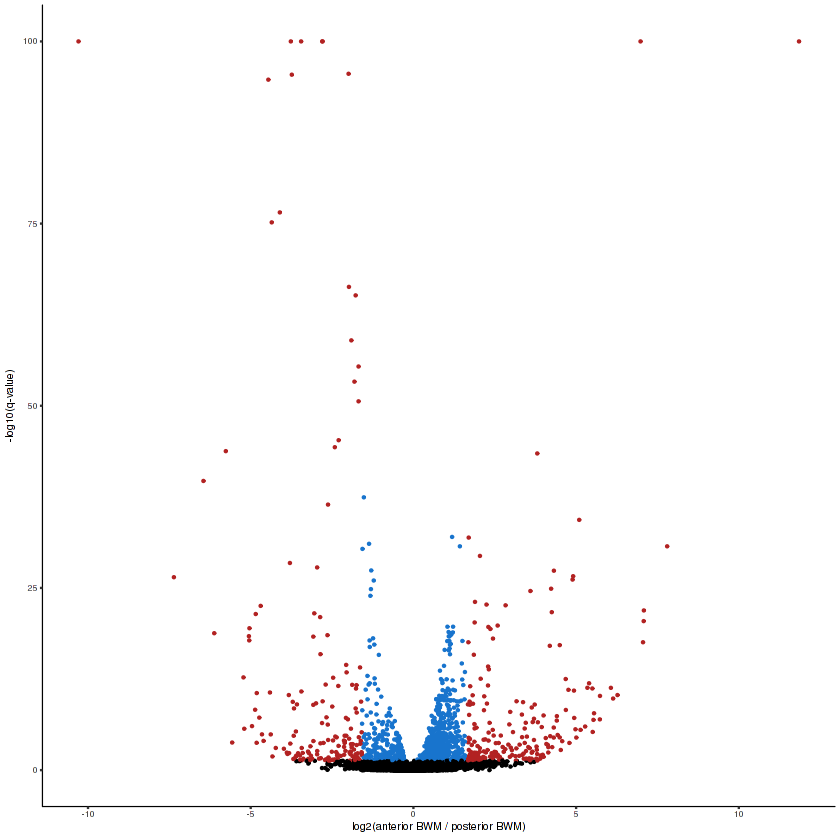

In [122]:
BWM.AP.DE.genes$sig.group = with(BWM.AP.DE.genes, ifelse(
    qval < 0.05 & abs(log2.fc) >= log2(3), "Significant, FC >= 3", ifelse(
    qval < 0.05, "Significant, FC < 3", "Not significant")))

BWM.AP.DE.genes$sig.group = factor(BWM.AP.DE.genes$sig.group, levels = c(
    "Significant, FC >= 3", "Significant, FC < 3", "Not significant"))

summary(BWM.AP.DE.genes$sig.group)

plot = ggplot(BWM.AP.DE.genes, aes(x = log2.fc, y = pmin(100, -log10(qval)), color = sig.group)) +
    geom_point(size = 0.2) +
    scale_color_manual(values = c("firebrick", "dodgerblue3", "black")) +
    xlab("log2(anterior BWM / posterior BWM)") +
    ylab("-log10(q-value)") +
    guides(color = F) +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts()

show(plot)

ggsave("plots/Fig_S8b.pdf", plot = plot,
    device = cairo_pdf, units = "in", width = 2.2, height = 2.2)

In [110]:
cds.intestine = cds.experiment.2[, with(pData(cds.experiment.2), !is.na(cell.type) & cell.type == "Intestine")]

fData(cds.intestine)$gene_id = fData(cds.intestine)$gene
cds.intestine@reducedDimA = cds.intestine@reducedDimA[,
    with(pData(cds.experiment.2), !is.na(cell.type) & cell.type == "Intestine")]

cds.intestine = detectGenes(cds.intestine, 0.1)

Distance cutoff calculated to 0.7632969 


the length of the distance: 130305


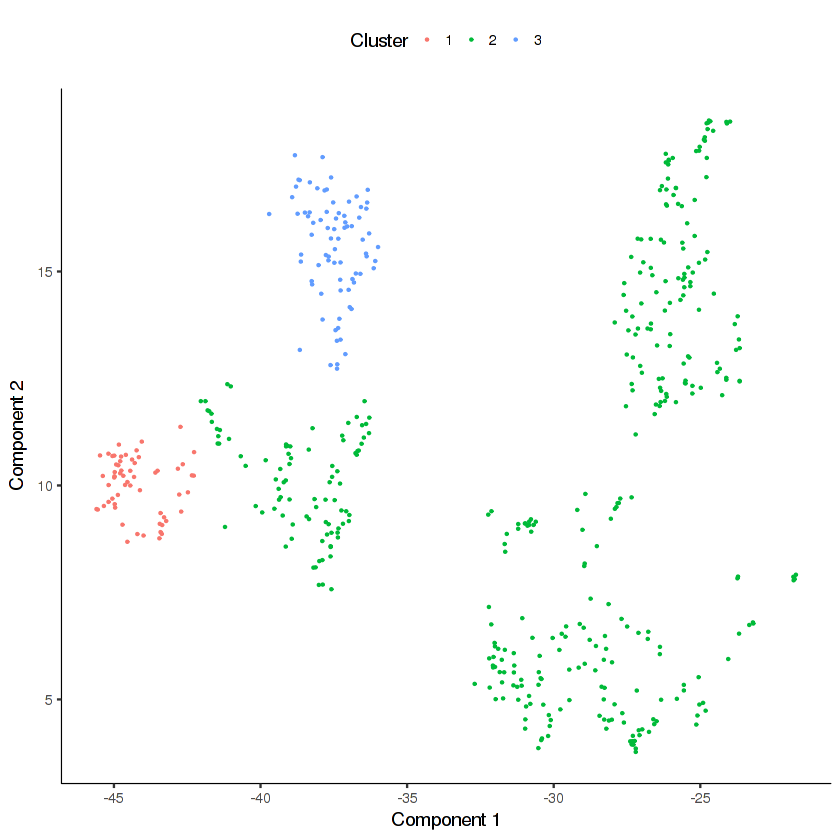

In [111]:
cds.intestine = clusterCells_Density_Peak(cds.intestine)
plot_cell_clusters(cds.intestine, cell_size = 0.2)

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

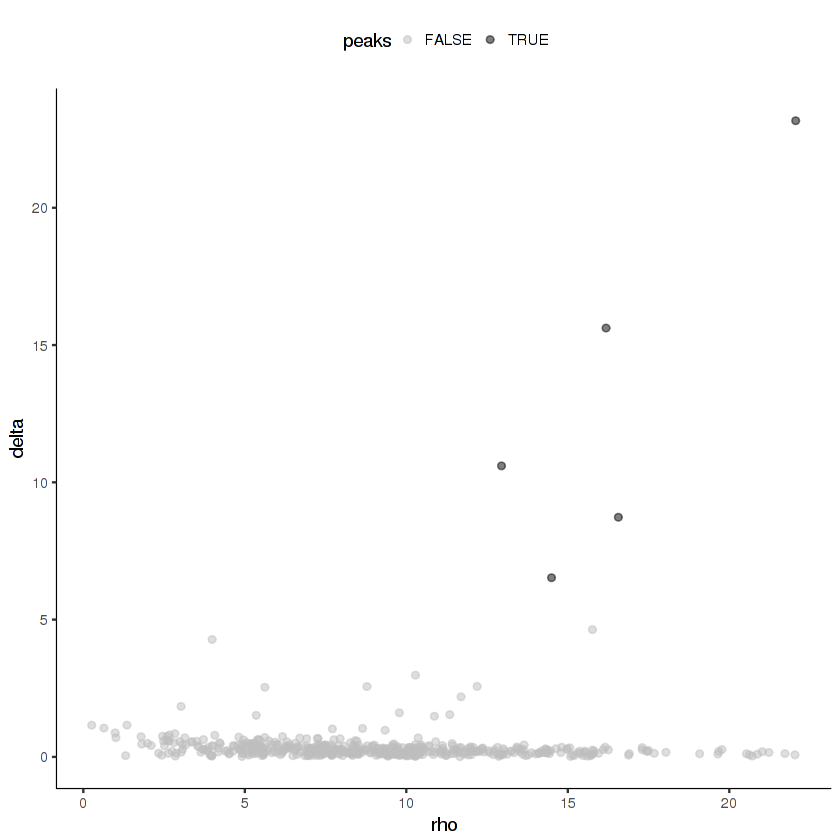

In [112]:
plot_rho_delta(cds.intestine, rho_threshold = 10, delta_threshold = 5)

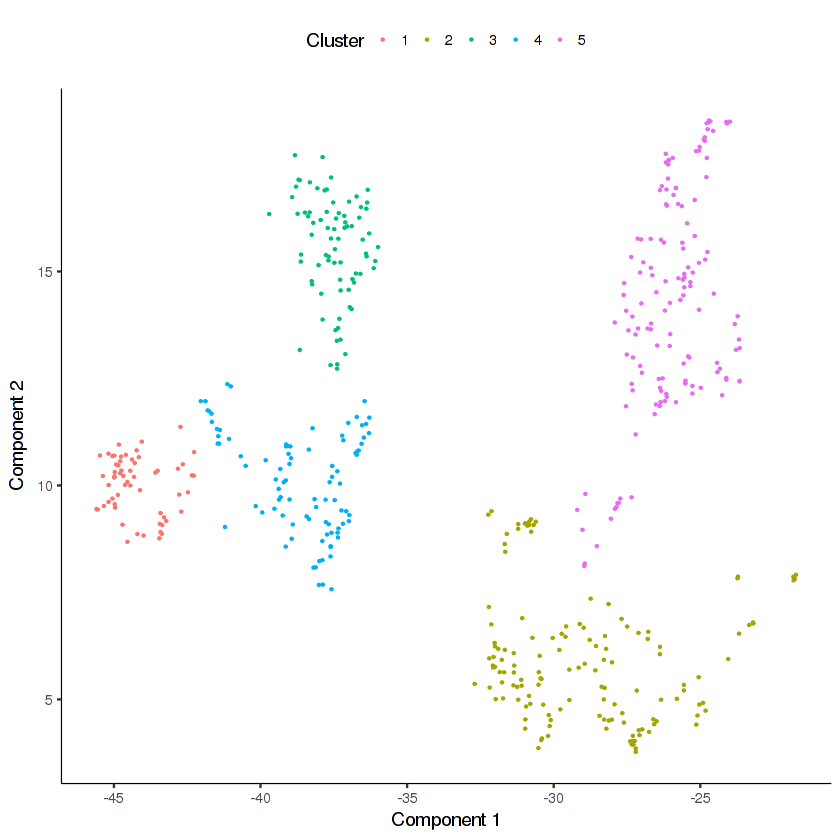

In [113]:
cds.intestine = clusterCells_Density_Peak(cds.intestine, rho_threshold = 10, delta_threshold = 5, skip_rho_sigma = T)
plot_cell_clusters(cds.intestine, cell_size = 0.2)

In [114]:
pData(cds.intestine)$pbo.4 = expresses.gene(cds.intestine, "pbo-4")
pData(cds.intestine)$nob.1 = expresses.gene(cds.intestine, "nob-1")

pData(cds.intestine)$marker.gene = with(pData(cds.intestine), ifelse(
    pbo.4 + nob.1 > 1, "pbo-4 and nob-1", ifelse(
    pbo.4, "pbo-4", ifelse(
    nob.1, "nob-1", "Neither"))))

pData(cds.intestine)$marker.gene = factor(pData(cds.intestine)$marker.gene, levels = c(
    "pbo-4 and nob-1", "pbo-4", "nob-1", "Neither"))

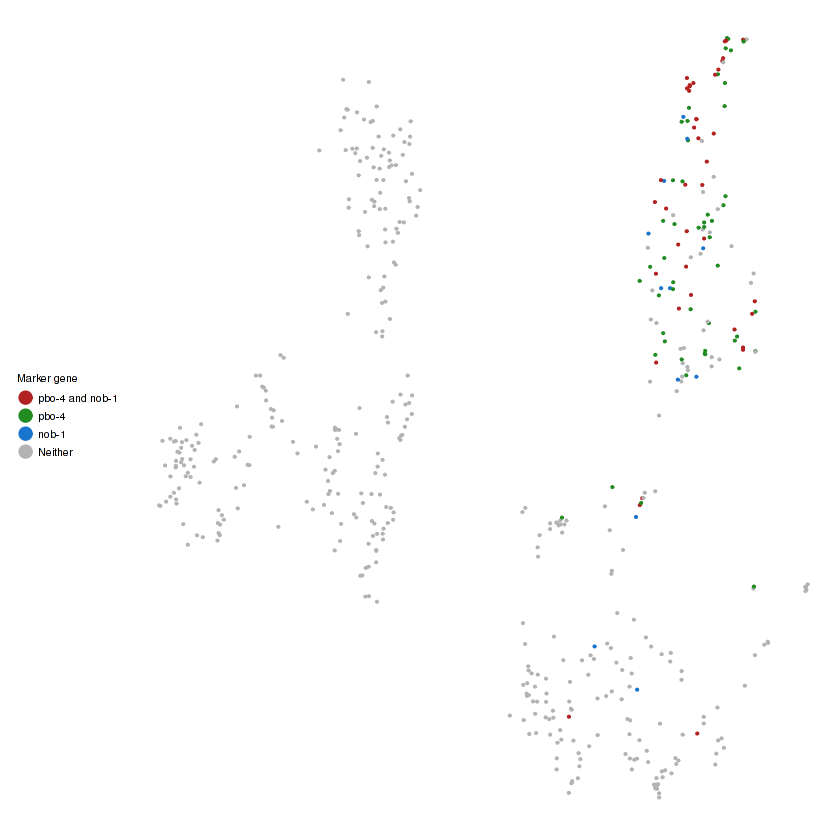

In [115]:
plot = ggplot(pData(cds.intestine), aes(x = tsne_1, y = tsne_2, color = marker.gene, alpha = marker.gene)) +
    geom_point(size = 0.1) +
    scale_color_manual(values = c("firebrick", "forestgreen", "dodgerblue3", "grey70")) +
    scale_alpha_manual(values = c(1, 1, 1, 1, 1.0/3.0)) +
    guides(
        color = guide_legend(title = "Marker gene", override.aes = list(size = 3)),
        alpha = F) +
    theme_void() +
    monocle:::monocle_theme_opts() +
    theme(
        axis.line = element_blank(),
        legend.position = "left",
        legend.title = element_text(size=6),
        legend.text = element_text(size=6),
        legend.margin = margin(0, -10, 0, 10),
        legend.key.width = unit(0.15, "in"),
        legend.key.height = unit(0.15, "in"))

show(plot)

ggsave("plots/Fig_S8c.pdf", plot = plot,
    device = cairo_pdf, units = "in", width = 3, height = 2.5)

In [116]:
pData(cds.intestine)$ap = with(pData(cds.intestine), ifelse(
    Cluster == 5 & (pbo.4 | nob.1), "Posterior", ifelse(
    Cluster != 5 & !(pbo.4 | nob.1), "Other", NA)))

pData(cds.intestine)$ap = factor(pData(cds.intestine)$ap, levels = c("Posterior", "Other"))

cds.intestine.ap = cds.intestine[, !is.na(pData(cds.intestine)$ap)]
cds.intestine.ap = detectGenes(cds.intestine.ap, 0.1)
summary(cds.intestine.ap$ap)

expressed.genes = subset(fData(cds.intestine.ap), num_cells_expressed >= 10)$gene_id
length(expressed.genes)

Posterior     Other 
       97       366

[1] 5834

In [117]:
intestine.AP.DE.genes = differentialGeneTest(cds.intestine.ap[expressed.genes,],
    fullModelFormulaStr = "~ ap")

In [118]:
intestine.AP.norm.means = sapply(c("Posterior", "Other"), function(x) {
    rowMeans(norm.expr[, pData(cds)$cell %in% subset(pData(cds.intestine.ap), ap == x)$cell])
})

rownames(intestine.AP.norm.means) = fData(cds)$symbol

In [120]:
intestine.AP.DE.genes = inner_join(intestine.AP.DE.genes, data.frame(
    symbol = row.names(intestine.AP.norm.means), 
    posterior.tpm = (intestine.AP.norm.means[, "Posterior"] / sum(intestine.AP.norm.means[, "Posterior"])) * 1000000,
    other.tpm = (intestine.AP.norm.means[, "Other"] / sum(intestine.AP.norm.means[, "Other"])) * 1000000
), by = "symbol") %>% mutate(
    P.O.ratio = posterior.tpm / (other.tpm + 1),
    O.P.ratio = other.tpm / (posterior.tpm + 1),
    log2.fc = ifelse(P.O.ratio > 1, log2(P.O.ratio), -log2(O.P.ratio))) %>% select(
    gene_id, symbol, qval, posterior.tpm, other.tpm, log2.fc)

In [121]:
sum(intestine.AP.DE.genes$qval < 0.05 & abs(intestine.AP.DE.genes$log2.fc) >= log2(3))
intestine.AP.DE.genes %>% arrange(qval) %>% head(10)

[1] 89

gene_id,symbol,qval,posterior.tpm,other.tpm,log2.fc
WBGene00018237,drd-2,1.370911e-59,18812.31647,611.227242,4.941466
WBGene00206522,F14D2.19,1.232758e-22,1099.19154,6.861421,7.127437
WBGene00003943,pbo-4,3.028709e-22,1054.09750,0.000000,10.041793
WBGene00012018,T25C12.3,1.382322e-18,8823.30610,1248.977628,2.819417
WBGene00006404,tag-10,6.340998e-18,14.87314,2711.753307,-7.416495
WBGene00008741,F13D12.6,6.541163e-18,12.01041,2350.836115,-7.497364
WBGene00007331,pho-11,7.614253e-18,862.63562,6.820013,6.785437
WBGene00015609,math-4,4.084326e-15,667.04618,2.834655,7.442546
WBGene00017418,F13B6.3,1.320593e-14,680.79303,10.349459,5.906521
WBGene00000785,cpr-5,6.058135e-14,17.17881,1676.558940,-6.527102


Significant, FC >= 3  Significant, FC < 3      Not significant 
                  89                    7                 5738

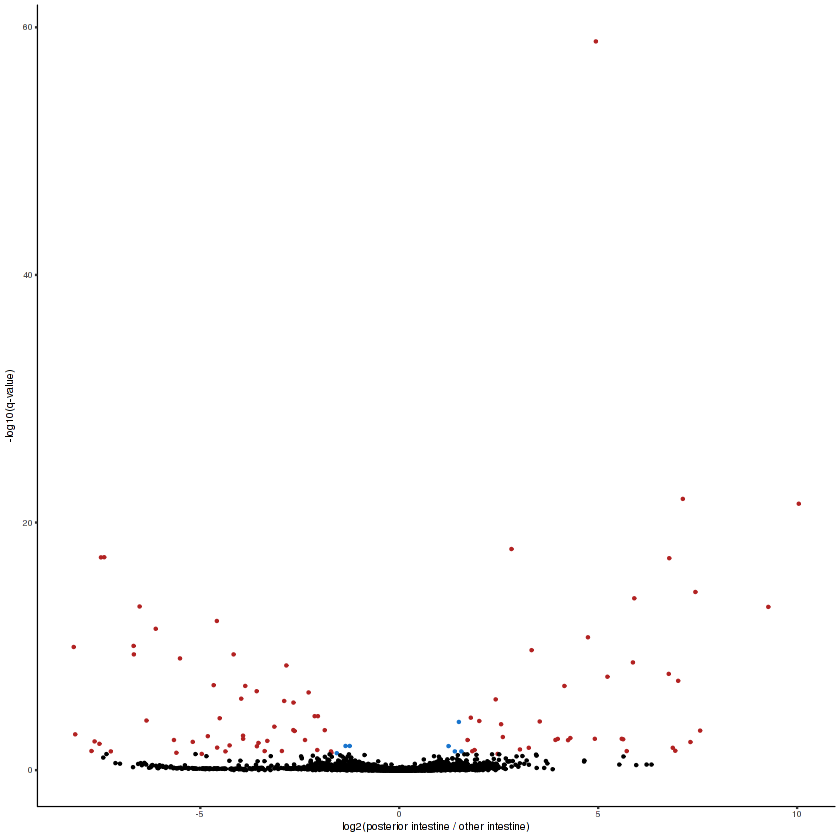

In [123]:
intestine.AP.DE.genes$sig.group = with(intestine.AP.DE.genes, ifelse(
    qval < 0.05 & abs(log2.fc) >= log2(3), "Significant, FC >= 3", ifelse(
    qval < 0.05, "Significant, FC < 3", "Not significant")))

intestine.AP.DE.genes$sig.group = factor(intestine.AP.DE.genes$sig.group, levels = c(
    "Significant, FC >= 3", "Significant, FC < 3", "Not significant"))

summary(intestine.AP.DE.genes$sig.group)

plot = ggplot(intestine.AP.DE.genes, aes(x = log2.fc, y = pmin(100, -log10(qval)), color = sig.group)) +
    geom_point(size = 0.2) +
    scale_color_manual(values = c("firebrick", "dodgerblue3", "black")) +
    xlab("log2(posterior intestine / other intestine)") +
    ylab("-log10(q-value)") +
    guides(color = F) +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts()

show(plot)

ggsave("plots/Fig_S8d.pdf", plot = plot,
    device = cairo_pdf, units = "in", width = 2.2, height = 2.2)

In [30]:
cds.sheath = cds.experiment.1[, with(pData(cds.experiment.1),
    !is.na(cell.type) & cell.type == "Am/PH sheath cells")]

cds.sheath@reducedDimA = cds.sheath@reducedDimA[,
    with(pData(cds.experiment.1), !is.na(cell.type) & cell.type == "Am/PH sheath cells")]

cds.sheath = detectGenes(cds.sheath, 0.1)

In [55]:
pData(cds.sheath)$vap.1 = expresses.gene(cds.sheath, "vap-1")
pData(cds.sheath)$fig.1 = expresses.gene(cds.sheath, "fig-1")

pData(cds.sheath)$marker.gene = with(pData(cds.sheath), ifelse(
    vap.1, "vap-1", ifelse(
    fig.1 & !vap.1, "fig-1 but not vap-1", ifelse(
    fig.1 & vap.1, "fig-1 and vap-1", "Neither"))))

pData(cds.sheath)$marker.gene = factor(pData(cds.sheath)$marker.gene, levels = c(
    "vap-1", "fig-1 but not vap-1", "fig-1 and vap-1", "Neither"))

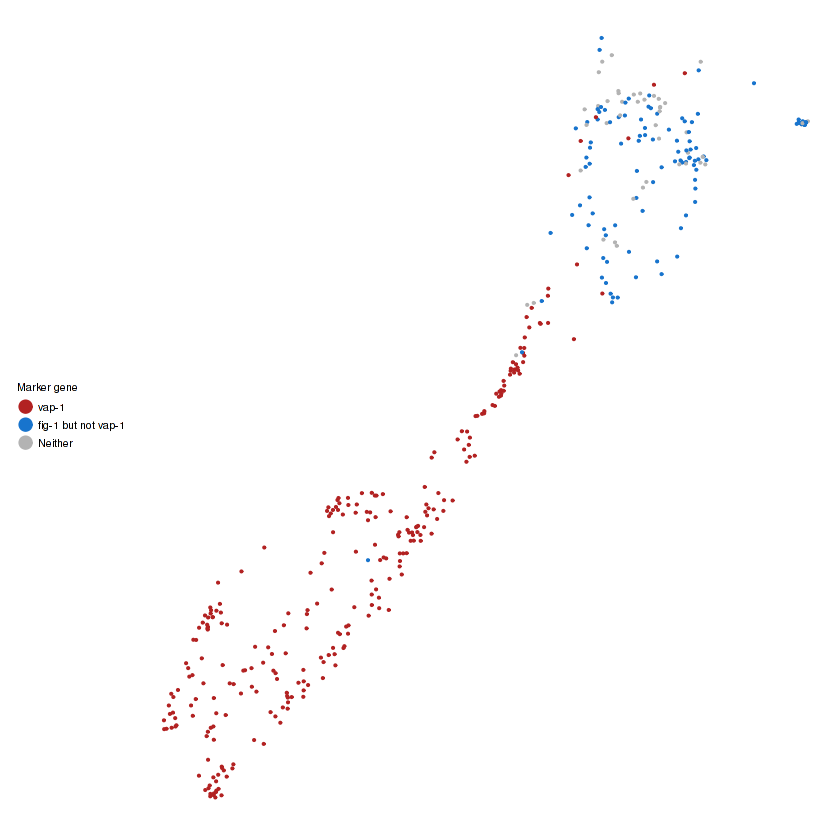

In [56]:
plot = ggplot(pData(cds.sheath), aes(x = tsne_1, y = tsne_2, color = marker.gene, alpha = marker.gene)) +
    geom_point(size = 0.1) +
    scale_color_manual(values = c("firebrick", "dodgerblue3", "grey70")) +
    scale_alpha_manual(values = c(1, 1, 1, 1, 1.0/3.0)) +
    guides(
        color = guide_legend(title = "Marker gene", override.aes = list(size = 3)),
        alpha = F) +
    theme_void() +
    monocle:::monocle_theme_opts() +
    theme(
        axis.line = element_blank(),
        legend.position = "left",
        legend.title = element_text(size=6),
        legend.text = element_text(size=6),
        legend.margin = margin(0, -10, 0, 10),
        legend.key.width = unit(0.15, "in"),
        legend.key.height = unit(0.15, "in"))

show(plot)

ggsave("plots/Fig_S8e.pdf", plot = plot,
    device = cairo_pdf, units = "in", width = 3, height = 2.5)

In [127]:
pData(cds.sheath)$ap = with(pData(cds.sheath), ifelse(
    vap.1 & fig.1 & Cluster == 8, "Amphid", ifelse(
    !vap.1 & fig.1 & Cluster == 15, "Phasmid", NA)))

pData(cds.sheath)$ap = factor(pData(cds.sheath)$ap, levels = c("Amphid", "Phasmid"))

cds.sheath.ap = cds.sheath[, !is.na(pData(cds.sheath)$ap)]
cds.sheath.ap = detectGenes(cds.sheath.ap, 0.1)
summary(cds.sheath.ap$ap)

expressed.genes = subset(fData(cds.sheath.ap), num_cells_expressed >= 10)$gene_id
length(expressed.genes)

Amphid Phasmid 
    227     102

[1] 3312

In [128]:
sheath.AP.DE.genes = differentialGeneTest(cds.sheath.ap[expressed.genes,],
    fullModelFormulaStr = "~ ap")

In [129]:
sheath.AP.norm.means = sapply(c("Amphid", "Phasmid"), function(x) {
    rowMeans(norm.expr[, pData(cds)$cell %in% subset(pData(cds.sheath.ap), ap == x)$cell])
})

rownames(sheath.AP.norm.means) = fData(cds)$symbol

In [131]:
sheath.AP.DE.genes = inner_join(sheath.AP.DE.genes, data.frame(
    symbol = row.names(sheath.AP.norm.means), 
    amphid.tpm = (sheath.AP.norm.means[, "Amphid"] / sum(sheath.AP.norm.means[, "Amphid"])) * 1000000,
    phasmid.tpm = (sheath.AP.norm.means[, "Phasmid"] / sum(sheath.AP.norm.means[, "Phasmid"])) * 1000000
), by = "symbol") %>% mutate(
    A.P.ratio = amphid.tpm / (phasmid.tpm + 1),
    P.A.ratio = phasmid.tpm / (amphid.tpm + 1),
    log2.fc = ifelse(A.P.ratio > 1, log2(A.P.ratio), -log2(P.A.ratio))) %>% select(
    gene_id, symbol, qval, amphid.tpm, phasmid.tpm, log2.fc)

In [132]:
sum(sheath.AP.DE.genes$qval < 0.05 & abs(sheath.AP.DE.genes$log2.fc) >= log2(3))
sheath.AP.DE.genes %>% arrange(qval) %>% head(10)

[1] 237

gene_id,symbol,qval,amphid.tpm,phasmid.tpm,log2.fc
WBGene00006886,vap-1,1.771089e-55,16871.770904,0.00000,14.042324
WBGene00010516,K02E11.7,2.950313e-41,2.978850,4372.57630,-10.101916
WBGene00019563,K09C6.9,9.166503e-35,9263.556554,59.63029,7.255384
WBGene00020054,R13D7.2,1.152162e-30,6887.751097,156.66308,5.449116
WBGene00001392,far-8,6.760963e-21,32545.519267,3459.10592,3.233571
WBGene00022230,Y73B6A.3,9.342284e-20,2334.418329,19.84600,6.807149
WBGene00017376,F11C7.2,5.936356e-18,5004.444361,128.03884,5.277333
WBGene00022093,Y69A2AR.22,1.409605e-15,9633.280581,1014.92012,3.245240
WBGene00015710,C12D5.9,1.245858e-13,1787.149231,82.57979,4.418362
WBGene00008707,F11E6.3,2.702694e-13,4.423389,1095.34614,-7.657976


Significant, FC >= 3  Significant, FC < 3      Not significant 
                 237                   95                 2980

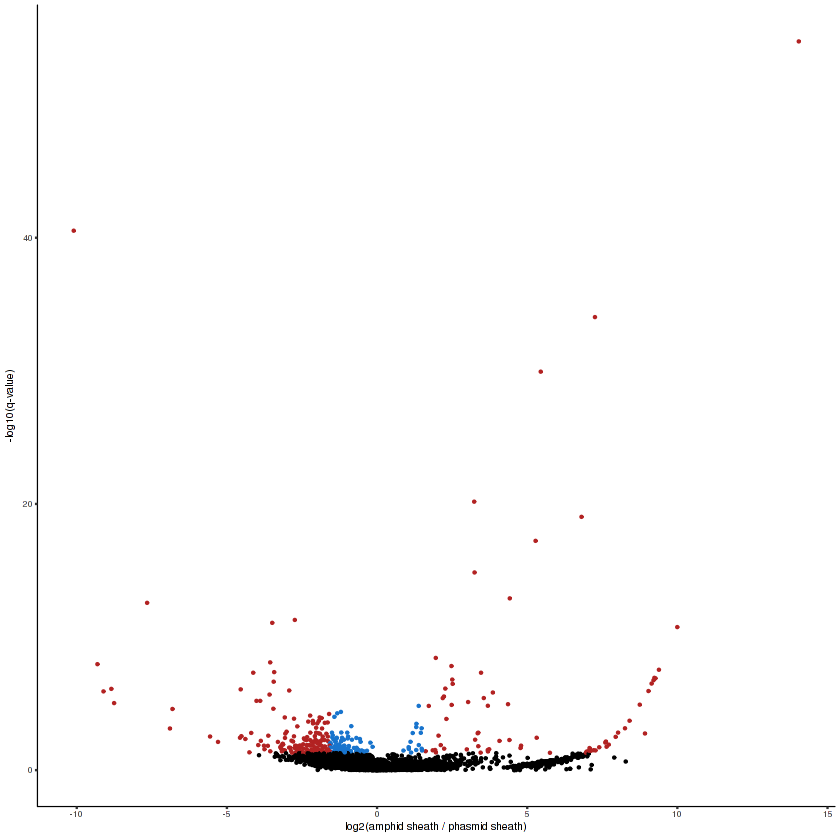

In [133]:
sheath.AP.DE.genes$sig.group = with(sheath.AP.DE.genes, ifelse(
    qval < 0.05 & abs(log2.fc) >= log2(3), "Significant, FC >= 3", ifelse(
    qval < 0.05, "Significant, FC < 3", "Not significant")))

sheath.AP.DE.genes$sig.group = factor(sheath.AP.DE.genes$sig.group, levels = c(
    "Significant, FC >= 3", "Significant, FC < 3", "Not significant"))

summary(sheath.AP.DE.genes$sig.group)

plot = ggplot(sheath.AP.DE.genes, aes(x = log2.fc, y = pmin(100, -log10(qval)), color = sig.group)) +
    geom_point(size = 0.2) +
    scale_color_manual(values = c("firebrick", "dodgerblue3", "black")) +
    xlab("log2(amphid sheath / phasmid sheath)") +
    ylab("-log10(q-value)") +
    guides(color = F) +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts()

show(plot)

ggsave("plots/Fig_S8f.pdf", plot = plot,
    device = cairo_pdf, units = "in", width = 2.2, height = 2.2)

In [137]:
write.table(BWM.AP.DE.genes[, 1:6] %>% arrange(qval), file = "tables/Table_S9.tsv",
    sep = "\t", row.names = F, col.names = T, quote = F)

write.table(intestine.AP.DE.genes[, 1:6] %>% arrange(qval), file = "tables/Table_S10.tsv",
    sep = "\t", row.names = F, col.names = T, quote = F)

write.table(sheath.AP.DE.genes[, 1:6] %>% arrange(qval), file = "tables/Table_S11.tsv",
    sep = "\t", row.names = F, col.names = T, quote = F)

In [ ]:
save.image("RData/L2.anterior.posterior.stuff.RData")